***Create a synthetic dataset for two particles in a harmonic potential trap, with a Coulomb potential between the two.***

Here we have two particles in 1D. Note the fixed points where the Coulomb repulsion and harmonic potential cancel each other out.

Since the $|q_0-q_1|<.10$ region creates numerical instability as the values for $|\ddot{q}|$ become very large and run into rounding errors, I am discarding any points that fall in this region. 

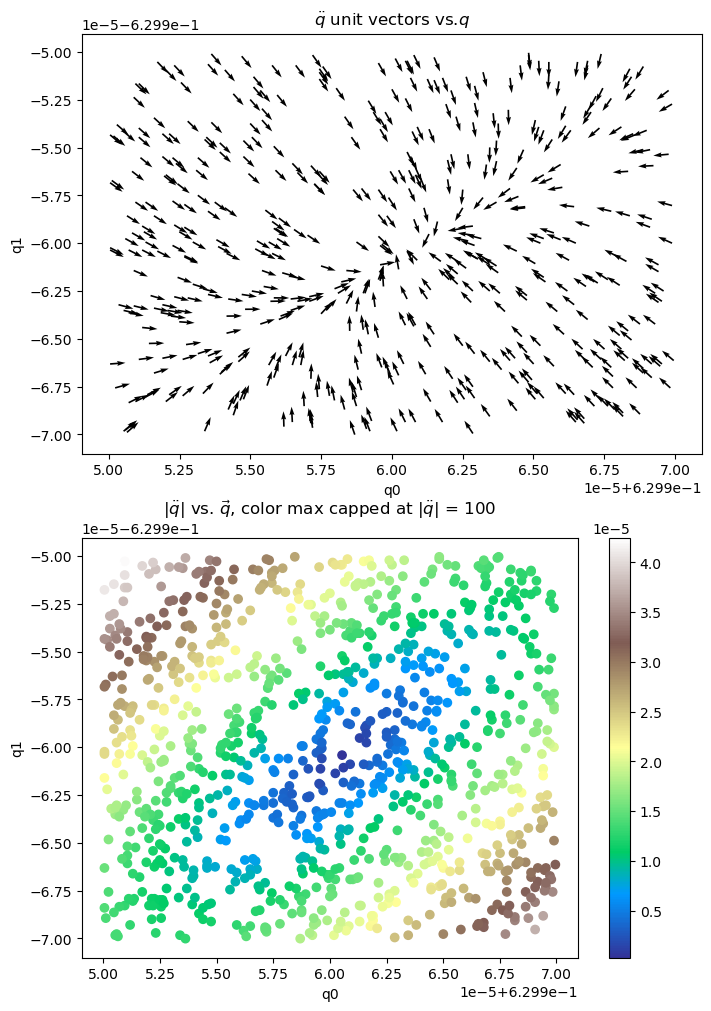

In [393]:
##### import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from torch.func import jacfwd, jacrev, vmap
import time
import torch
from torch import tensor, sum, log, max

#####
# problem setup

m = torch.tensor([1],dtype=torch.float64)
k = torch.tensor([1],dtype=torch.float64)
alpha = torch.tensor([1],dtype=torch.float64) #charge0*charge1

n_points = 1000
q0_min = .62995
q0_max = .62997
q1_min = -.62997
q1_max = -.62995
dist_threshold = 0.20
qdot_min = -1
qdot_max = 1

#####
# function definitions

def L(qv,qdotv,m,k,alpha): #including Coulomb potential
    return sum(0.5*m*qdotv**2) - sum(0.5*k*qv**2) - alpha*( 1/ (qv[0]-qv[1])**2 )**.5

def QDD(Q,QD,m,k,alpha):
    g_q2 = jacrev(L,argnums=0)(Q,QD,m,k,alpha)
    g_qdot2 = jacrev(L,argnums=1)(Q,QD,m,k,alpha)
    
    g_q_qdot2 = jacrev(jacrev(L,argnums=1),argnums=0)(Q,QD,m,k,alpha)
    g_qdot_q2 = jacrev(jacrev(L,argnums=0),argnums=1)(Q,QD,m,k,alpha)
    g_qdot_qdot2 = jacrev(jacrev(L,argnums=1),argnums=1)(Q,QD,m,k,alpha)
    D = torch.linalg.pinv(g_qdot_qdot2)
    #print(g_q_qdot2@QD.T)
    #print(D@(g_q2 - g_q_qdot2@QD.T).T)
    return (D@(g_q2 - g_q_qdot2@QD.T).T).reshape(Q.shape)

def QDD_true(Q,QD,m,k,alpha): #for testing if output is as expected for alpha=0
    QDD = -k/m*Q
    return QDD

QDDv = vmap(QDD,in_dims=(0,0,None,None,None))


q0_sampling = (q0_max - q0_min)*(torch.rand(n_points)) + q0_min
q1_sampling = (q1_max - q1_min)*(torch.rand(n_points)) + q1_min
qdot_sampling = (qdot_max - qdot_min)*(torch.rand([2,n_points])) + qdot_min

Q0 = q0_sampling
Q1 = q1_sampling
QD0 = qdot_sampling[0,:]
QD1 = qdot_sampling[1,:]

reject_Q = abs(Q0-Q1) >= dist_threshold

Q0 = Q0[reject_Q]
Q1 = Q1[reject_Q]
QD0 = QD0[reject_Q]
QD1 = QD1[reject_Q]

n_points = Q0.size()[0]

im = 0*torch.zeros([n_points,n_points])
#print(im.shape)



Qv = torch.zeros(n_points,2)
Qv[:,0] = Q0
Qv[:,1] = Q1

QDv = torch.zeros(n_points,2)
QDv[:,0] = QD0
QDv[:,1] = QD1

out = QDDv(Qv,QDv,m,k,alpha)
outmag = (out[:,0]**2 + out[:,1]**2)**.5
#print(out)

#####
# plotting

quiver_points = 500 #define how many arrows to quiver plot
if quiver_points > n_points: #if specified value greater than number of points analyzed
    quiver_points = n_points #set quiver_points to n_points
fig,axs = plt.subplots(2,1,figsize=(8,12))
axs[0].quiver(Qv[:quiver_points,0],Qv[:quiver_points,1],out[:quiver_points,0]/outmag[:quiver_points],out[:quiver_points,1]/outmag[:quiver_points])
axs[0].set_xlabel('q0')
axs[0].set_ylabel('q1')
axs[0].set_title(r'$\ddot{q}$ unit vectors vs.$q$')

cmax = 100
scatter = axs[1].scatter(Qv[:,0],Qv[:,1],c=np.min([outmag , cmax*torch.ones(n_points)],axis=0),cmap='terrain')
plt.colorbar(scatter,ax=axs[1])
axs[1].set_xlabel('q0')
axs[1].set_ylabel('q1')
axs[1].set_title(r'$|\ddot{q}|$ vs. $\vec{q}$, color max capped at $|\ddot{q}|$ = ' + f'{cmax}')


plt.show()

***Given this synthetic dataset, visualize the loss landscape***

$l = \frac{1}{N}\sum_i^N \Big( \ddot{q}_i - d_i\Big)^2$

This is the standard $L^2$ loss function, and has performed best through all of my current trials.


100%|██████████| 200/200 [00:15<00:00, 12.53it/s]


The original parameters are m = 1.0, k = 1.0


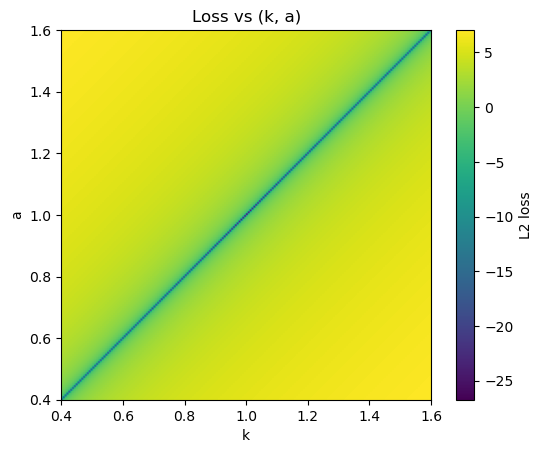

In [395]:
n_param_points_k = 200
n_param_points_a = 200
box_width_k = 0.60*k[0]
box_width_a = 0.60*alpha[0]

k_min = k[0] - box_width_k
k_max = k[0] + box_width_k
a_min = alpha[0] - box_width_a
a_max = alpha[0] + box_width_a

ktrialgrid = torch.linspace(k_min,k_max,n_param_points_k)
atrialgrid = torch.linspace(a_min,a_max,n_param_points_a)

timing_comparison = 0

def loss(q,qdot,m,k,alpha,dataset):
    test_qdd = QDD(q,qdot,m,k,alpha)
    return torch.sum(( (test_qdd - dataset) )**2 )#/(dataset.size()[0]**2)

lossv = vmap(loss,in_dims=(0,0,None,None,0,0))

loss_mat = torch.zeros([n_param_points_k, n_param_points_a])



sz = out.size(1)
qdd_trials = torch.zeros(sz)

#reformat dataset to take advantage of vectorization
outvt, Qvt, QDvt = out, Qv, QDv
if n_param_points_a >1:
    for i in range(1,n_param_points_a): #there's probably a better way to do this, but it works for now
        outvt = torch.cat((outvt,out))
        Qvt = torch.cat((Qvt,Qv))
        QDvt = torch.cat((QDvt,QDv))

for i in tqdm.trange(n_param_points_k): #iterate over m
    ktrial = tensor([ktrialgrid[i]], requires_grad = True) #pick k_trial value from grid
    atvec = atrialgrid.expand(Q0.size()[0],n_param_points_a).reshape(-1)    

    sz_expand = Qvt.size()[0]

    lv = lossv(Qvt,QDvt,m,ktrial,atvec,outvt)
    loss_mat[i,:] = lv.reshape(int(sz_expand/n_param_points_a),n_param_points_a).sum(axis=0)


if timing_comparison == 1:
    loss_alt_mat = torch.zeros([n_param_points_k, n_param_points_a])
    for i in tqdm.trange(n_param_points_k): #iterate over m
        ktrial = tensor([ktrialgrid[i]], requires_grad = True) #pick k_trial value from grid
        for j in range(n_param_points_a): #iterate over k
            atrial = tensor([atrialgrid[j]], requires_grad = True) #pick a_trial value from grid
    
            #qdd_trials = QDDv(Q,QD,mtrial,ktrial,alpha)
            
            #loss_mat[i,j] = torch.sum( (qdd_trials - out)**2 )/sz #calculate loss function
            loss_alt_mat[i,j] = loss_alt(Qv,QDv,m,ktrial,atrial,out)


print(f"The original parameters are m = {m[0]}, k = {k[0]}")

#plotting

plt.imshow(np.log(loss_mat.detach().numpy().T+1e-12), extent=[k_min,k_max,a_min,a_max],origin='lower',aspect=box_width_k/box_width_a)
plt.xlabel('k')
plt.ylabel('a')
plt.colorbar(label='L2 loss')
plt.title("Loss vs (k, a)")
plt.show()



Here I perform gradient descent on the typical $L^2$ loss function.

100%|██████████| 12/12 [01:29<00:00,  7.46s/it]


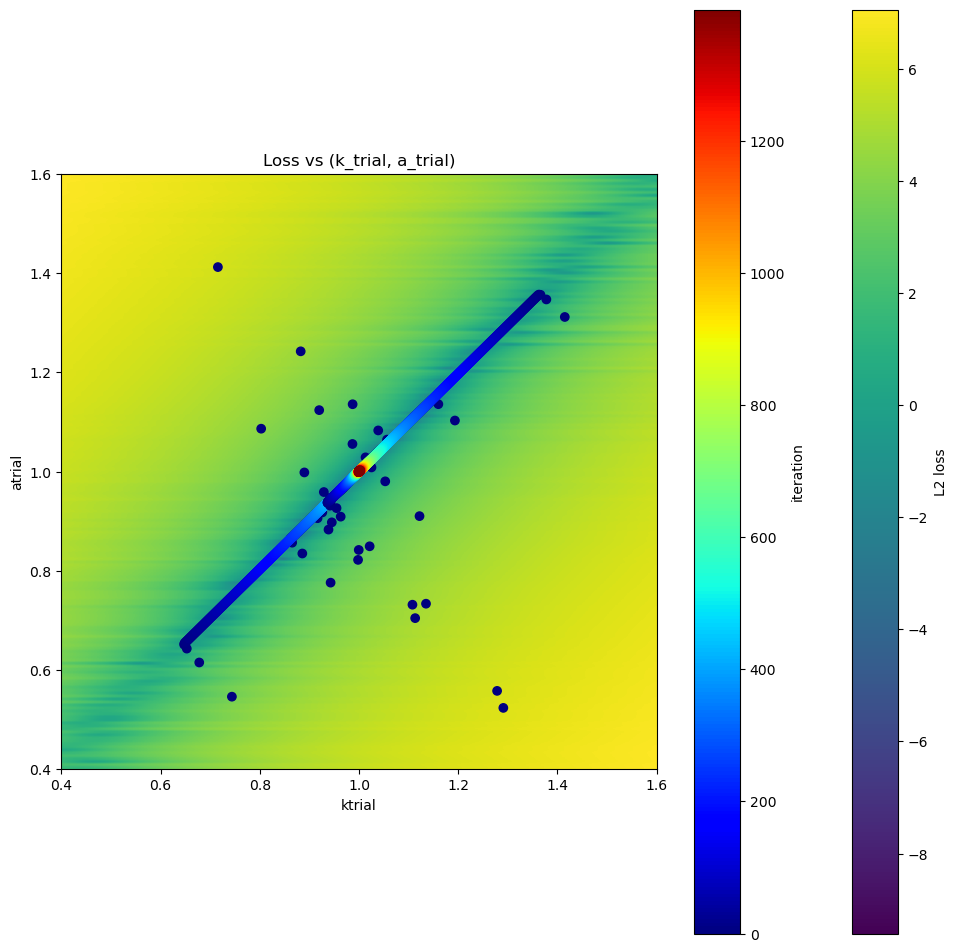

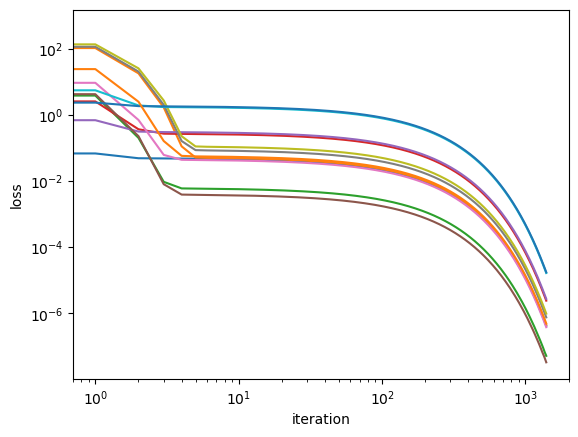

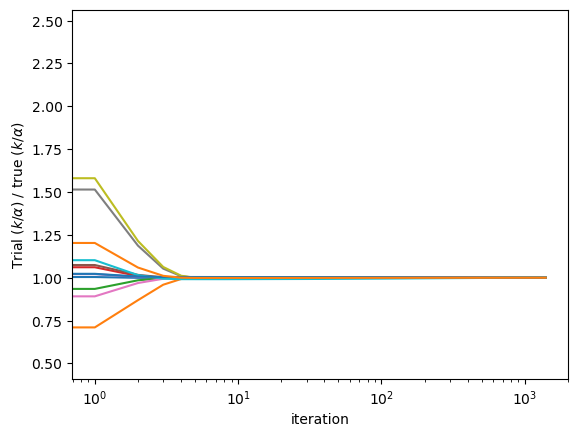

In [366]:
def loss_alt(q,qdot,m,k,alpha,dataset):
    test_qdd = QDDv(q,qdot,m,k,alpha)
    return torch.sum(( (test_qdd - dataset) )**2 )

#####
# define gradient w.r.t. parameters
dlossdk_alt = jacrev(loss_alt,argnums=3)
dlossda_alt = jacrev(loss_alt,argnums=4)

n_trials = 12
trial_iters = 1400
learning_rate = 3e-4

box_width_k_guess = 0.50*k[0]
box_width_a_guess = 0.50*alpha[0]

out_w_grad = out
out_w_grad.requires_grad = True

#plot loss landscape
fig, axs = plt.subplots(1,1,figsize=(12,12))

loss_bkgd = axs.imshow(np.log(loss_mat.detach().numpy().T+1e-12), extent=[k_min,k_max,a_min,a_max],origin='lower',aspect=box_width_k/box_width_a)
axs.set_xlabel('ktrial')
axs.set_ylabel('atrial')
plt.colorbar(loss_bkgd, ax=axs,label='L2 loss')
axs.set_title("Loss vs (k_trial, a_trial)")

guess_k_array = torch.zeros([trial_iters,n_trials])
guess_a_array = torch.zeros([trial_iters,n_trials])
iter_array = torch.arange(0,trial_iters,1)
loss_hist = torch.zeros([trial_iters,n_trials])


guess_k = tensor([0])
guess_a = tensor([0])

guesses_k = box_width_k_guess*2*(torch.rand(n_trials)-0.5)+k[0]
guesses_a = box_width_a_guess*2*(torch.rand(n_trials)-0.5)+alpha[0]

for j in tqdm.trange(n_trials):
    guess_k = torch.clone(guesses_k[j])
    guess_a = torch.clone(guesses_a[j])
    for i in range(trial_iters):
        guess_k_array[i,j] = torch.clone(guess_k)
        guess_a_array[i,j] = torch.clone(guess_a)

        loss_hist[i,j] = loss_alt(Qv,QDv,m,guess_k,guess_a,out_w_grad)
        
        dldk = dlossdk_alt(Qv,QDv,m,guess_k,guess_a,out_w_grad)
        dlda = dlossda_alt(Qv,QDv,m,guess_k,guess_a,out_w_grad)
        d_tot = (dldk**2 + dlda**2)**.5
        d_scale = torch.exp(-(learning_rate*d_tot)**.5)**1
        
        guess_k.data += -learning_rate*dldk*d_scale
        guess_a.data += -learning_rate*dlda*d_scale

        
        
points = axs.scatter(guess_k_array[:,0],guess_a_array[:,0],c=iter_array,cmap='jet')
if n_trials >= 2:
    for i in range(1,n_trials):
        axs.scatter(guess_k_array[:,i],guess_a_array[:,i],c=iter_array,cmap='jet')

plt.colorbar(points,ax=axs, label='iteration')
axs.set_xlim(left= (k[0] - box_width_k), right = k[0] + box_width_k)
axs.set_ylim(bottom=alpha[0] - box_width_a, top = alpha[0] + box_width_a)

plt.show()

loss_hist = loss_hist.detach().numpy()

plt.plot(iter_array,loss_hist[:,0],label='trial 0')
if n_trials >= 2:
    for i in range(1,n_trials):
        plt.plot(iter_array,loss_hist[:,i],label=f'trial {i}')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.xscale('log')
plt.yscale('log')
#plt.legend()
plt.show()

plt.plot(iter_array,(guess_k_array/guess_a_array)[:,0]/(k[0]/alpha[0]),label='trial 0')
if n_trials >= 2:
    for i in range(1,n_trials):
        plt.plot(iter_array,(guess_k_array/guess_a_array)[:,i]/(k[0]/alpha[0]),label=f'trial {i}')
plt.xlabel('iteration')
plt.ylabel(r'Trial $(k/\alpha)$ / true $(k/\alpha)$')
plt.xscale('log')
#plt.yscale('log')
#plt.legend()
plt.show()

Here I perform gradient descent on the $\log(L^2)$ loss function. Generally, most initial conditions appear to be converging towards the correct parameters, but very slowly. 

Compared to the standard $L^2$ loss function, this function produces much wilder failures when the learning rate becomes too large. Instead of mild oscillations, it produces wild swings around the minima that can be as large as ~10%.

Some initial conditions also appear to diverge away from the true parameter values, I'm not sure why.